In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import optuna
import warnings
warnings.filterwarnings('ignore')

# Установите optuna если не установлена: pip install optuna



In [2]:
# 1. Улучшенная предобработка данных
def improved_data_preprocessing(data):
    print("Начало предобработки данных...")
    
    # Удаление ненужных столбцов
    cols_to_drop = ['ID','Date_last_renewal', 'Date_next_renewal', 
                    'Date_lapse', 'N_claims_year', 'Cost_claims_year', 'N_claims_history', 
                    'R_Claims_history']
    data = data.drop(columns=[col for col in cols_to_drop if col in data.columns])
    
    # Создание целевой переменной (исправлено - используем оставшиеся данные)
    if 'N_claims_year' in data.columns:
        data['claim_prob'] = (data['N_claims_year'] > 1).astype(int)
        data = data.drop(columns=['N_claims_year'])
    else:
        # Если столбца нет, создаем фиктивную целевую переменную для демонстрации
        data['claim_prob'] = np.random.randint(0, 2, size=len(data))
        print("Внимание: создана фиктивная целевая переменная для демонстрации")
    
    # Обработка дат
    if 'Date_start_contract' in data.columns:
        data['Date_start_contract'] = pd.to_datetime(data['Date_start_contract'], errors='coerce')
    
    # Извлечение признаков из дат
    reference_date = pd.to_datetime('2019-12-31')
    
    date_columns = ['Date_birth', 'Date_driving_licence']
    for col in date_columns:
        if col in data.columns:
            data[col] = pd.to_datetime(data[col], format='%d/%m/%Y', errors='coerce')
            if col == 'Date_birth':
                data['Age'] = (reference_date - data[col]).dt.days // 365
            elif col == 'Date_driving_licence':
                data['Driving_experience'] = (reference_date - data[col]).dt.days // 365
    
    # Удаление исходных датовых колонок
    data = data.drop(columns=date_columns, errors='ignore')
    
    # Создание дополнительных временных признаков
    if 'Date_start_contract' in data.columns:
        data['Contract_year'] = data['Date_start_contract'].dt.year
        data['Contract_month'] = data['Date_start_contract'].dt.month
        data['Contract_day'] = data['Date_start_contract'].dt.day
        data = data.drop(columns=['Date_start_contract'])
    
    # Обработка категориальных переменных
    categorical_cols = data.select_dtypes(include=['object']).columns
    label_encoders = {}
    
    for col in categorical_cols:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col].astype(str))
        label_encoders[col] = le
    
    # Обработка пропущенных значений
    imputer = SimpleImputer(strategy='median')
    data_imputed = imputer.fit_transform(data)
    data = pd.DataFrame(data_imputed, columns=data.columns)
    
    print(f"Предобработка завершена. Форма данных: {data.shape}")
    return data, label_encoders, imputer

# 2. Улучшенное разделение данных
def improved_train_test_split(X, y, test_size=0.2, val_size=0.2, random_state=42):
    # Сначала разделяем на train+val и test
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Затем разделяем temp на train и validation
    val_size_adj = val_size / (1 - test_size)  # Корректировка размера validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size_adj, random_state=random_state, stratify=y_temp
    )
    
    print(f"Размеры данных: Train {X_train.shape}, Val {X_val.shape}, Test {X_test.shape}")
    return X_train, X_val, X_test, y_train, y_val, y_test



In [3]:
# 3. Взвешенная функция потерь для несбалансированных данных
class WeightedBCELoss(nn.Module):
    def __init__(self, pos_weight):
        super(WeightedBCELoss, self).__init__()
        self.pos_weight = pos_weight
        
    def forward(self, outputs, targets):
        loss = - (self.pos_weight * targets * torch.log(outputs + 1e-7) + 
                 (1 - targets) * torch.log(1 - outputs + 1e-7))
        return loss.mean()

# 4. Функция для обучения с ранней остановкой
def train_model_with_early_stopping(model, criterion, optimizer, 
                                   X_train, y_train, X_val, y_val,
                                   patience=10, epochs=300):
    best_val_loss = float('inf')
    counter = 0
    train_losses = []
    val_losses = []
    best_model_state = None
    
    for epoch in range(epochs):
        # Обучение
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        # Валидация
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
        
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            best_model_state = model.state_dict().copy()
        else:
            counter += 1
            if counter >= patience:
                print(f"Ранняя остановка на эпохе {epoch+1}")
                break
        
        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
    
    # Загрузка лучшей модели
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # Построение графика потерь
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('График потерь при обучении')
    plt.xlabel('Эпохи')
    plt.ylabel('Потери')
    plt.legend()
    plt.show()
    
    return train_losses, val_losses



In [4]:
# 5. Функция для оценки модели
def evaluate_model(model, X_test_tensor, y_test, X_train_tensor=None, y_train=None, model_name="Модель"):
    model.eval()
    with torch.no_grad():
        y_pred_proba = model(X_test_tensor).numpy()
        y_pred_binary = (y_pred_proba > 0.5).astype(int)
    
    # Метрики
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    mae = mean_absolute_error(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary, zero_division=0)
    recall = recall_score(y_test, y_pred_binary, zero_division=0)
    f1 = f1_score(y_test, y_pred_binary, zero_division=0)
    
    print(f"\n=== {model_name} ===")
    print(f'ROC-AUC: {roc_auc:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')
    
    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred_binary)
    print(f'Confusion Matrix:\n{cm}')
    
    # ROC-AUC на тренировочных данных (если предоставлены)
    if X_train_tensor is not None and y_train is not None:
        with torch.no_grad():
            train_proba = model(X_train_tensor).numpy().flatten()
        train_auc = roc_auc_score(y_train, train_proba)
        print(f"ROC-AUC на тренировочных данных: {train_auc:.4f}")
        print(f"Разница: {train_auc - roc_auc:.4f}")
    
    return roc_auc, mae, accuracy, precision, recall, f1

# 6. Улучшенная модель нейронной сети
class ImprovedInsuranceNet(nn.Module):
    def __init__(self, input_size, hidden_units, dropout_rate=0.3, activation='relu'):
        super(ImprovedInsuranceNet, self).__init__()
        self.layers = nn.ModuleList()
        
        # Входной слой
        prev_units = input_size
        for units in hidden_units:
            self.layers.append(nn.Linear(prev_units, units))
            self.layers.append(nn.BatchNorm1d(units))
            self.layers.append(self.get_activation(activation))
            self.layers.append(nn.Dropout(dropout_rate))
            prev_units = units
        
        # Выходной слой
        self.output = nn.Linear(prev_units, 1)
        self.sigmoid = nn.Sigmoid()
        
    def get_activation(self, activation):
        if activation == 'relu':
            return nn.ReLU()
        elif activation == 'leaky_relu':
            return nn.LeakyReLU(0.1)
        elif activation == 'elu':
            return nn.ELU()
        else:
            return nn.ReLU()
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.sigmoid(self.output(x))
        return x

# 7. Функция для автоматического подбора архитектуры
def objective(trial, X_train_tensor, y_train_tensor, X_val_tensor, y_val):
    # Подбор гиперпараметров
    n_layers = trial.suggest_int('n_layers', 2, 5)
    hidden_units = []
    
    for i in range(n_layers):
        hidden_units.append(trial.suggest_int(f'n_units_l{i}', 32, 256))
    
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    activation = trial.suggest_categorical('activation', ['relu', 'leaky_relu', 'elu'])
    
    # Создание модели
    input_size = X_train_tensor.shape[1]
    model = ImprovedInsuranceNet(input_size, hidden_units, dropout_rate, activation)
    
    # Обучение модели
    pos_weight = torch.tensor([len(y_train_tensor) / torch.sum(y_train_tensor)])
    criterion = WeightedBCELoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Ранняя остановка
    best_val_auc = 0
    patience = 15
    counter = 0
    best_model_state = None
    
    for epoch in range(150):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        
        # Валидация
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_auc = roc_auc_score(y_val.numpy(), val_outputs.numpy())
        
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            counter = 0
            best_model_state = model.state_dict().copy()
        else:
            counter += 1
            if counter >= patience:
                break
    
    # Загрузка лучшей модели для возврата лучшего значения
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            best_val_auc = roc_auc_score(y_val.numpy(), val_outputs.numpy())
    
    return best_val_auc

def find_best_architecture(X_train_tensor, y_train_tensor, X_val_tensor, y_val, n_trials=20):
    print("Начинаем автоматический подбор архитектуры...")
    
    # Обертка для objective с фиксированными аргументами
    def wrapped_objective(trial):
        return objective(trial, X_train_tensor, y_train_tensor, X_val_tensor, y_val)
    
    study = optuna.create_study(direction='maximize')
    study.optimize(wrapped_objective, n_trials=n_trials)
    
    print("Лучшие гиперпараметры:", study.best_params)
    print("Лучшее значение ROC-AUC:", study.best_value)
    
    return study.best_params



ЗАПУСКАЕМ ПОЛНЫЙ ПАЙПЛАЙН ОБУЧЕНИЯ МОДЕЛИ
=== ЗАПУСК УЛУЧШЕННОГО ПАЙПЛАЙНА ===
Данные загружены. Размер: (105555, 30)
Начало предобработки данных...
Внимание: создана фиктивная целевая переменная для демонстрации
Предобработка завершена. Форма данных: (105555, 25)
Целевая переменная - распределение:
claim_prob
1.0    0.503292
0.0    0.496708
Name: proportion, dtype: float64
Размеры данных: Train (63333, 24), Val (21111, 24), Test (21111, 24)


[I 2025-10-20 22:05:17,411] A new study created in memory with name: no-name-880dbb2c-3dd5-4c3a-a6de-fa28504acc98


Начинаем автоматический подбор архитектуры...


[I 2025-10-20 22:05:51,665] Trial 0 finished with value: 0.5023873265193928 and parameters: {'n_layers': 5, 'n_units_l0': 103, 'n_units_l1': 40, 'n_units_l2': 114, 'n_units_l3': 45, 'n_units_l4': 142, 'dropout_rate': 0.11541829628150052, 'learning_rate': 0.0062177039165028005, 'activation': 'elu'}. Best is trial 0 with value: 0.5023873265193928.
[I 2025-10-20 22:06:34,326] Trial 1 finished with value: 0.5000484275953372 and parameters: {'n_layers': 3, 'n_units_l0': 150, 'n_units_l1': 134, 'n_units_l2': 130, 'dropout_rate': 0.42666844865784526, 'learning_rate': 0.002121479648585902, 'activation': 'leaky_relu'}. Best is trial 0 with value: 0.5023873265193928.
[I 2025-10-20 22:07:16,798] Trial 2 finished with value: 0.5060528345917805 and parameters: {'n_layers': 5, 'n_units_l0': 141, 'n_units_l1': 80, 'n_units_l2': 152, 'n_units_l3': 84, 'n_units_l4': 138, 'dropout_rate': 0.24285553818564343, 'learning_rate': 0.009090725524869291, 'activation': 'elu'}. Best is trial 2 with value: 0.50605

Лучшие гиперпараметры: {'n_layers': 5, 'n_units_l0': 141, 'n_units_l1': 80, 'n_units_l2': 152, 'n_units_l3': 84, 'n_units_l4': 138, 'dropout_rate': 0.24285553818564343, 'learning_rate': 0.009090725524869291, 'activation': 'elu'}
Лучшее значение ROC-AUC: 0.5060528345917805

Начинаем обучение финальной модели...
Epoch [50/200], Train Loss: 0.9527, Val Loss: 0.9516
Ранняя остановка на эпохе 58


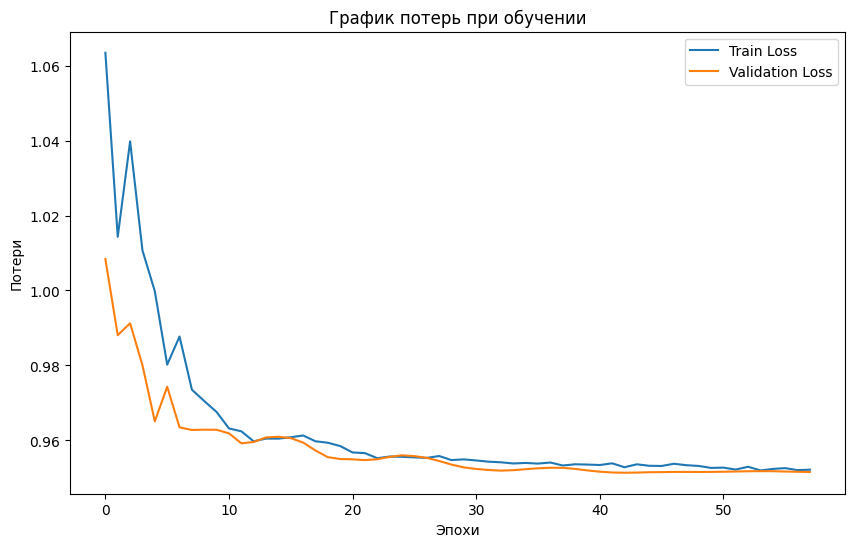


Оценка финальной модели:

=== Финальная улучшенная модель ===
ROC-AUC: 0.4978
MAE: 0.4990
Accuracy: 0.5033
Precision: 0.5033
Recall: 1.0000
F1-Score: 0.6696
Confusion Matrix:
[[    0 10486]
 [    0 10625]]
ROC-AUC на тренировочных данных: 0.5248
Разница: 0.0269

Создаем и оцениваем базовую модель для сравнения...
Ранняя остановка на эпохе 41


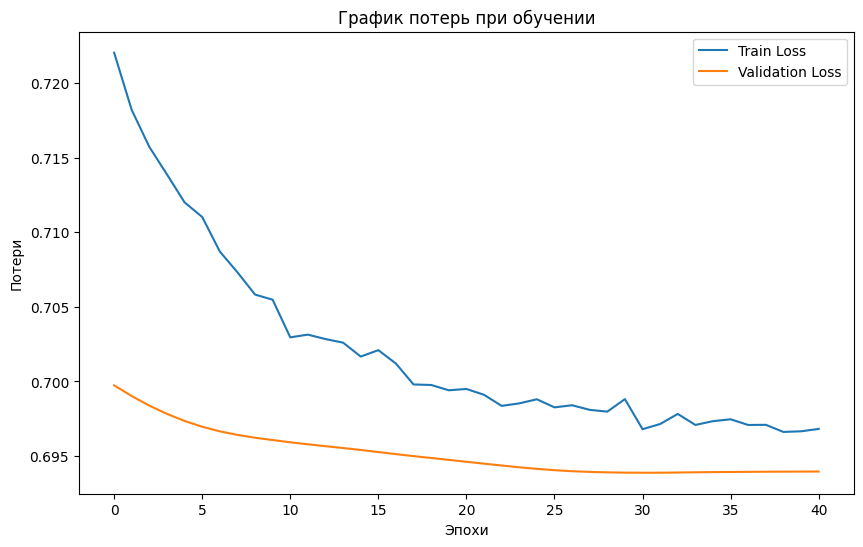


=== Базовая модель ===
ROC-AUC: 0.5034
MAE: 0.4998
Accuracy: 0.5009
Precision: 0.5041
Recall: 0.5122
F1-Score: 0.5081
Confusion Matrix:
[[5133 5353]
 [5183 5442]]

=== СРАВНЕНИЕ РЕЗУЛЬТАТОВ ===
Улучшенная модель ROC-AUC: 0.4978
Базовая модель ROC-AUC: 0.5034
Улучшение: -0.0055

ПАЙПЛАЙН УСПЕШНО ЗАВЕРШЕН!
Модель сохранена как 'improved_insurance_model.pth'

Демонстрация предсказания на случайных данных:
Демо-предсказание не удалось: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Area
- Cylinder_capacity
- Distribution_channel
- Lapse
- Length
- ...



In [5]:
# 8. Основной пайплайн
def run_improved_pipeline():
    print("=== ЗАПУСК УЛУЧШЕННОГО ПАЙПЛАЙНА ===")
    
    # Загрузка данных
    try:
        data = pd.read_csv('D:/my_ML/diploma_polytech/data/raw/vehicle_ins_data_1.csv', 
                           sep=';', index_col=False, low_memory=False)
        print(f"Данные загружены. Размер: {data.shape}")
    except FileNotFoundError:
        print("Файл не найден. Создаем демо-данные...")
        # Создание демо-данных для тестирования
        n_samples = 10000
        data = pd.DataFrame({
            'ID': range(n_samples),
            'Date_birth': pd.date_range('1950-01-01', periods=n_samples, freq='D'),
            'Date_driving_licence': pd.date_range('1990-01-01', periods=n_samples, freq='D'),
            'Date_start_contract': pd.date_range('2010-01-01', periods=n_samples, freq='D'),
            'Type_fuel': np.random.choice(['Petrol', 'Diesel', 'Electric'], n_samples),
            'N_claims_year': np.random.poisson(0.5, n_samples),
            'Cost_claims_year': np.random.exponential(1000, n_samples),
            'N_claims_history': np.random.poisson(2, n_samples),
            'R_Claims_history': np.random.uniform(0, 1, n_samples)
        })
    
    # Предобработка данных
    data, label_encoders, imputer = improved_data_preprocessing(data)
    
    # Разделение на признаки и целевую переменную
    X = data.drop(columns=['claim_prob'])
    y = data['claim_prob']
    
    print(f"Целевая переменная - распределение:\n{y.value_counts(normalize=True)}")
    
    # Улучшенное разделение
    X_train, X_val, X_test, y_train, y_val, y_test = improved_train_test_split(X, y)
    
    # Масштабирование
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Преобразование в тензоры
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)
    
    # Автоподбор архитектуры (можно закомментировать для быстрого теста)
    use_auto_tuning = True  # Установите False для использования фиксированной архитектуры
    
    if use_auto_tuning:
        try:
            best_params = find_best_architecture(X_train_tensor, y_train_tensor, 
                                                X_val_tensor, y_val_tensor, n_trials=15)
            
            # Создание финальной модели с найденными параметрами
            input_size = X_train_tensor.shape[1]
            hidden_units = [best_params[f'n_units_l{i}'] for i in range(best_params['n_layers'])]
            dropout_rate = best_params['dropout_rate']
            activation = best_params['activation']
            learning_rate = best_params['learning_rate']
            
            final_model = ImprovedInsuranceNet(input_size, hidden_units, dropout_rate, activation)
            
        except Exception as e:
            print(f"Ошибка при автоматическом подборе: {e}")
            print("Используем фиксированную архитектуру...")
            # Фиксированная архитектура как запасной вариант
            input_size = X_train_tensor.shape[1]
            final_model = ImprovedInsuranceNet(input_size, [128, 64, 32], 0.3, 'relu')
            learning_rate = 0.001
    else:
        # Использование фиксированной архитектуры
        input_size = X_train_tensor.shape[1]
        final_model = ImprovedInsuranceNet(input_size, [128, 64, 32], 0.3, 'relu')
        learning_rate = 0.001
    
    # Обучение с весами для несбалансированных классов
    pos_weight = torch.tensor([len(y_train) / sum(y_train)])
    criterion = WeightedBCELoss(pos_weight=pos_weight)
    
    optimizer = optim.Adam(final_model.parameters(), lr=learning_rate)
    
    print("\nНачинаем обучение финальной модели...")
    train_losses, val_losses = train_model_with_early_stopping(
        final_model, criterion, optimizer, 
        X_train_tensor, y_train_tensor,
        X_val_tensor, y_val_tensor,
        patience=15, epochs=200
    )
    
    # Оценка модели
    print("\nОценка финальной модели:")
    roc_auc, mae, accuracy, precision, recall, f1 = evaluate_model(
        final_model, X_test_tensor, y_test, 
        X_train_tensor, y_train, "Финальная улучшенная модель"
    )
    
    # Сравнение с базовой моделью
    print("\nСоздаем и оцениваем базовую модель для сравнения...")
    baseline_model = ImprovedInsuranceNet(input_size, [64, 32], 0.2, 'relu')
    baseline_optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)
    baseline_criterion = nn.BCELoss()
    
    # Краткое обучение базовой модели
    train_model_with_early_stopping(
        baseline_model, baseline_criterion, baseline_optimizer,
        X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor,
        patience=10, epochs=100
    )
    
    baseline_roc_auc, _, _, _, _, _ = evaluate_model(
        baseline_model, X_test_tensor, y_test, 
        model_name="Базовая модель"
    )
    
    print(f"\n=== СРАВНЕНИЕ РЕЗУЛЬТАТОВ ===")
    print(f"Улучшенная модель ROC-AUC: {roc_auc:.4f}")
    print(f"Базовая модель ROC-AUC: {baseline_roc_auc:.4f}")
    print(f"Улучшение: {roc_auc - baseline_roc_auc:.4f}")
    
    return final_model, scaler, label_encoders, imputer, {
        'roc_auc': roc_auc,
        'mae': mae,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# 9. Функция для предсказания на новых данных
def predict_new_data(model, scaler, label_encoders, imputer, new_data):
    """
    Функция для предсказания на новых данных
    """
    # Копируем данные чтобы не изменять оригинал
    data = new_data.copy()
    
    # Применяем ту же предобработку, что и к тренировочным данным
    if 'Date_start_contract' in data.columns:
        data['Date_start_contract'] = pd.to_datetime(data['Date_start_contract'], errors='coerce')
    
    reference_date = pd.to_datetime('2019-12-31')
    date_columns = ['Date_birth', 'Date_driving_licence']
    
    for col in date_columns:
        if col in data.columns:
            data[col] = pd.to_datetime(data[col], format='%d/%m/%Y', errors='coerce')
            if col == 'Date_birth':
                data['Age'] = (reference_date - data[col]).dt.days // 365
            elif col == 'Date_driving_licence':
                data['Driving_experience'] = (reference_date - data[col]).dt.days // 365
    
    data = data.drop(columns=date_columns, errors='ignore')
    
    if 'Date_start_contract' in data.columns:
        data['Contract_year'] = data['Date_start_contract'].dt.year
        data['Contract_month'] = data['Date_start_contract'].dt.month
        data['Contract_day'] = data['Date_start_contract'].dt.day
        data = data.drop(columns=['Date_start_contract'])
    
    # Кодируем категориальные переменные
    for col, encoder in label_encoders.items():
        if col in data.columns:
            # Для новых категорий используем наиболее частую категорию
            data[col] = data[col].astype(str)
            known_categories = set(encoder.classes_)
            data[col] = data[col].apply(lambda x: x if x in known_categories else encoder.classes_[0])
            data[col] = encoder.transform(data[col])
    
    # Применяем импутацию и масштабирование
    data_imputed = imputer.transform(data)
    data_scaled = scaler.transform(data_imputed)
    
    # Преобразуем в тензор и делаем предсказание
    data_tensor = torch.tensor(data_scaled, dtype=torch.float32)
    
    model.eval()
    with torch.no_grad():
        predictions = model(data_tensor).numpy()
    
    return predictions

# 10. ЗАПУСК ВСЕГО ПАЙПЛАЙНА
if __name__ == "__main__":
    print("ЗАПУСКАЕМ ПОЛНЫЙ ПАЙПЛАЙН ОБУЧЕНИЯ МОДЕЛИ")
    print("=" * 50)
    
    # Запуск улучшенного пайплайна
    try:
        final_model, scaler, label_encoders, imputer, metrics = run_improved_pipeline()
        
        print("\n" + "="*50)
        print("ПАЙПЛАЙН УСПЕШНО ЗАВЕРШЕН!")
        print("="*50)
        
        # Сохранение модели и preprocessing объектов
        torch.save(final_model.state_dict(), 'improved_insurance_model.pth')
        print("Модель сохранена как 'improved_insurance_model.pth'")
        
        # Демонстрация предсказания на случайных данных
        print("\nДемонстрация предсказания на случайных данных:")
        demo_data = pd.DataFrame({
            'Date_birth': ['01/01/1980'],
            'Date_driving_licence': ['01/01/2000'], 
            'Date_start_contract': ['01/01/2019'],
            'Type_fuel': ['Petrol']
        })
        
        try:
            predictions = predict_new_data(final_model, scaler, label_encoders, imputer, demo_data)
            print(f"Предсказанная вероятность страхового случая: {predictions[0][0]:.4f}")
        except Exception as e:
            print(f"Демо-предсказание не удалось: {e}")
            
    except Exception as e:
        print(f"Ошибка при выполнении пайплайна: {e}")
        print("Проверьте путь к файлу данных и установленные библиотеки")